In [1]:
import time

t_debut = time.time()

import scipy
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score

from tools import datasets, convert_keys_to_int, PDF

pdf = PDF('output/selection_seuil/')

Importation de la liste des variables explicatives sélectionnées et des meilleurs paramètres pour chaque modèle.

In [2]:
best_LR = "LR_RFECV"
best_Forest = "Forest_RFECV"
best_XGBoost = "XGBoost_RFECV"

In [3]:
import json

# Régression logistique
with open('backups/RFECV_LR.json') as column_file:
    LR_COLUMNS = json.load(column_file)
    LR_COLUMNS_QUANT = LR_COLUMNS['columns_quant']
    LR_COLUMNS_CAT = LR_COLUMNS['columns_cat']
    LR_COLUMNS = LR_COLUMNS_QUANT + LR_COLUMNS_CAT

with open('backups/PARAMS_LR.json') as param_file:
    LR_PARAMS = json.load(param_file)[best_LR]
    LR_PARAMS = convert_keys_to_int(LR_PARAMS)

print(f'Variables explicatives régression logistique ({len(LR_COLUMNS)}) :')
display(LR_COLUMNS)

print(f'Meilleurs paramètres régression logistique ({len(LR_PARAMS)}) :')
display(LR_PARAMS)

# Forêts aléatoires
with open('backups/RFECV_Forest.json') as column_file:
    F_COLUMNS = json.load(column_file)
    F_COLUMNS_QUANT = F_COLUMNS['columns_quant']
    F_COLUMNS_CAT = F_COLUMNS['columns_cat']
    F_COLUMNS = F_COLUMNS_QUANT + F_COLUMNS_CAT

with open('backups/PARAMS_Forest.json') as param_file:
    F_PARAMS = json.load(param_file)[best_Forest]
    F_PARAMS = convert_keys_to_int(F_PARAMS)

print(f'Variables explicatives forêts aléatoires ({len(F_COLUMNS)}) :')
display(F_COLUMNS)

print(f'Meilleurs paramètres forêts aléatoires ({len(F_PARAMS)}) :')
F_PARAMS['class_weight'] = {int(k): v for k,v in F_PARAMS['class_weight'].items()}
display(F_PARAMS)

# XGBoost
with open('backups/RFECV_XGBoost.json') as column_file:
    XG_COLUMNS = json.load(column_file)
    XG_COLUMNS_QUANT = XG_COLUMNS['columns_quant']
    XG_COLUMNS_CAT = XG_COLUMNS['columns_cat']
    XG_COLUMNS = XG_COLUMNS_QUANT + XG_COLUMNS_CAT

with open('backups/PARAMS_XGBoost.json') as param_file:
    XG_PARAMS = json.load(param_file)[best_XGBoost]
    XG_PARAMS = convert_keys_to_int(XG_PARAMS)

print(f'Variables explicatives XGBoost ({len(XG_COLUMNS)}) :')
display(XG_COLUMNS)

print(f'Meilleurs paramètres XGBoost ({len(XG_PARAMS)}) :')
display(XG_PARAMS)

Variables explicatives régression logistique (11) :


['campaignctrlast24h',
 'display_size',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'zonecostineuro',
 'campaignscenario_13',
 'device_type_Desktop',
 'device_type_iPhone',
 'display_env_app_ios',
 'is_interstitial_True',
 'target_env_2']

Meilleurs paramètres régression logistique (2) :


{'C': 7.880462815669905, 'class_weight': {0: 1, 1: 20}}

Variables explicatives forêts aléatoires (9) :


['campaignctrlast24h',
 'contextid',
 'dayssincelastvisitdouble',
 'display_size',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'nbdisplayglobalapprox_1d_sum_xdevice',
 'zonecostineuro',
 'is_interstitial_True']

Meilleurs paramètres forêts aléatoires (8) :


{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'class_weight': {0: 1, 1: 32},
 'bootstrap': False,
 'n_jobs': -1}

Variables explicatives XGBoost (9) :


['campaignctrlast24h',
 'contextid',
 'nbdayssincelastclick',
 'nbdisplay_1hour',
 'zonecostineuro',
 'device_type_Android',
 'device_type_Desktop',
 'device_type_iPad',
 'is_interstitial_True']

Meilleurs paramètres XGBoost (11) :


{'subsample': 1.0,
 'scale_pos_weight': 16.5,
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 2,
 'learning_rate': 0.1,
 'gamma': 1.5,
 'colsample_bytree': 0.6,
 'booster': 'gbtree',
 'objective': 'binary:logistic',
 'n_jobs': -1}

# Régression logistique

In [4]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
datasets_df = datasets(df, columns_quant=LR_COLUMNS_QUANT, columns_cat=LR_COLUMNS_CAT, drop='first', verbose=False)
X = datasets_df['X_only_quant_scaled']
y = datasets_df['y']
X_train_LR, X_val_LR, y_train_LR, y_val_LR = train_test_split(X, y, train_size=0.80, random_state=1234)

In [5]:
%%time
clf = LogisticRegression(**LR_PARAMS)
clf.fit(X_train_LR, y_train_LR)

y_probas_LR = clf.predict_proba(X_val_LR)[:, 1]

CPU times: user 25.2 s, sys: 1min 6s, total: 1min 31s
Wall time: 2.03 s


In [6]:
def f3_LR(seuil):
    y_pred = (y_probas_LR >= seuil) * 1
    precision = precision_score(y_val_LR, y_pred)
    recall = recall_score(y_val_LR, y_pred)
    f3 = (10 * precision * recall) / (9 * precision + recall)
    return f3

f3_LR_v = np.vectorize(f3_LR)

In [7]:
[s_opt_LR] = scipy.optimize.fmin(lambda s: - f3_LR(s), 0.5)
print(f"Meilleur seuil : {s_opt_LR}")
print(f"Score F3 : {f3_LR(s_opt_LR)}")

Optimization terminated successfully.
         Current function value: -0.482729
         Iterations: 10
         Function evaluations: 23
Meilleur seuil : 0.4898437499999999
Score F3 : 0.4827287941182002


In [8]:
def graph_seuil(S, Y, opt):
    fig, ax = plt.subplots()
    plt.plot(S, Y)
    plt.axvline(x=0.5, color='black', linewidth=0.5, label="Seuil 0.5")
    plt.axvline(x=opt, color='red', linewidth=0.5, label="Seuil optimal")

    ax.set_xlim(0, 1)

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.grid(which='major')
    ax.grid(b=True, which='minor', axis='x', linestyle='--', alpha=0.3)
    ax.grid(b=True, which='minor', axis='y', linestyle='--', alpha=0.3)

    ax.set_xlabel("Seuil")
    ax.set_ylabel("Score F3") 

    plt.legend()
    pdf.export()
    plt.show()

Export PDF : output/selection_seuil/00.pdf



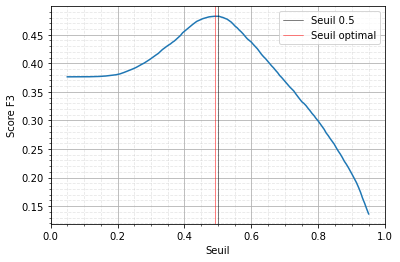

CPU times: user 26.6 s, sys: 269 ms, total: 26.8 s
Wall time: 26.6 s


In [9]:
%%time
S = np.linspace(0.05, 0.95, 150)
Y = f3_LR_v(S)
graph_seuil(S, Y, s_opt_LR)

# Forêts aléatoires

In [10]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
datasets_df = datasets(df, columns_quant=F_COLUMNS_QUANT, columns_cat=F_COLUMNS_CAT, verbose=False)
X = datasets_df['X']
y = datasets_df['y']
X_train_F, X_val_F, y_train_F, y_val_F = train_test_split(X, y, train_size=0.80, random_state=1234)

In [11]:
%%time
clf = RandomForestClassifier(**F_PARAMS)
clf.fit(X_train_F, y_train_F)

y_probas_F = clf.predict_proba(X_val_F)[:, 1]

CPU times: user 59min 33s, sys: 16.3 s, total: 59min 49s
Wall time: 1min 13s


In [12]:
def f3_F(seuil):
    y_pred = (y_probas_F >= seuil) * 1
    precision = precision_score(y_val_F, y_pred)
    recall = recall_score(y_val_F, y_pred)
    f3 = (10 * precision * recall) / (9 * precision + recall)
    return f3

f3_F_v = np.vectorize(f3_F)

In [13]:
[s_opt_F] = scipy.optimize.fmin(lambda s: - f3_F(s), 0.5)
print(f"Meilleur seuil : {s_opt_F}")
print(f"Score F3 : {f3_F(s_opt_F)}")

Optimization terminated successfully.
         Current function value: -0.534553
         Iterations: 12
         Function evaluations: 25
Meilleur seuil : 0.6426757812500004
Score F3 : 0.5345532396506488


Export PDF : output/selection_seuil/01.pdf



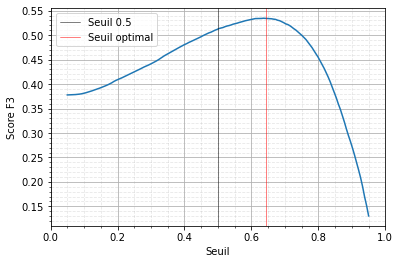

CPU times: user 28.9 s, sys: 313 ms, total: 29.2 s
Wall time: 28.9 s


In [14]:
%%time
S = np.linspace(0.05, 0.95, 150)
Y = f3_F_v(S)
graph_seuil(S, Y, s_opt_F)

# XGBoost

In [15]:
df = pd.read_csv('data/df_train_prepro.csv').sample(frac=1)
datasets_df = datasets(df, columns_quant=XG_COLUMNS_QUANT, columns_cat=XG_COLUMNS_CAT, verbose=False)
X = datasets_df['X']
y = datasets_df['y']
X_train_XG, X_val_XG, y_train_XG, y_val_XG = train_test_split(X, y, train_size=0.80, random_state=1234)

In [16]:
%%time
clf = XGBClassifier(**XG_PARAMS)
clf.fit(X_train_XG, y_train_XG)

y_probas_XG = clf.predict_proba(X_val_XG)[:, 1]

CPU times: user 5min 48s, sys: 3.02 s, total: 5min 51s
Wall time: 12.5 s


In [17]:
def f3_XG(seuil):
    y_pred = (y_probas_XG >= seuil) * 1
    precision = precision_score(y_val_XG, y_pred)
    recall = recall_score(y_val_XG, y_pred)
    f3 = (10 * precision * recall) / (9 * precision + recall)
    return f3

f3_XG_v = np.vectorize(f3_XG)

In [18]:
[s_opt_XG] = scipy.optimize.fmin(lambda s: - f3_XG(s), 0.5)
print(f"Meilleur seuil : {s_opt_XG}")
print(f"Score F3 : {f3_XG(s_opt_XG)}")

Optimization terminated successfully.
         Current function value: -0.537023
         Iterations: 10
         Function evaluations: 21
Meilleur seuil : 0.4701171874999999
Score F3 : 0.5370232903405401


Export PDF : output/selection_seuil/02.pdf



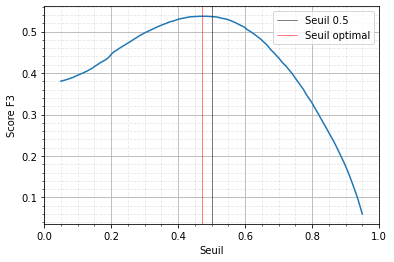

CPU times: user 29.3 s, sys: 544 ms, total: 29.9 s
Wall time: 29.6 s


In [19]:
%%time
S = np.linspace(0.05, 0.95, 150)
Y = f3_XG_v(S)
graph_seuil(S, Y, s_opt_XG)

Export PDF : output/selection_seuil/03.pdf



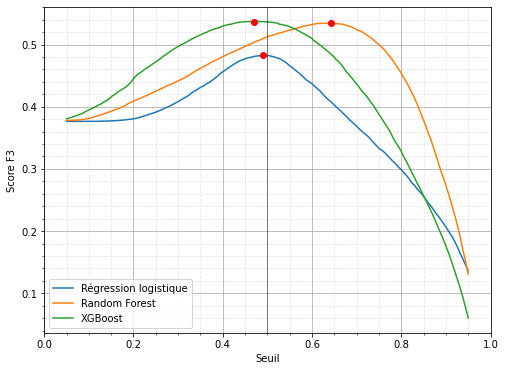

In [20]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(S, f3_LR_v(S), label="Régression logistique")
plt.plot(S, f3_F_v(S), label="Random Forest")
plt.plot(S, f3_XG_v(S), label="XGBoost")
plt.axvline(x=0.5, color='black', linewidth=0.5)

plt.plot(s_opt_LR, f3_LR_v(s_opt_LR), marker='o', color="red")
plt.plot(s_opt_F, f3_F_v(s_opt_F), marker='o', color="red")
plt.plot(s_opt_XG, f3_XG_v(s_opt_XG), marker='o', color="red")

ax.set_xlim(0, 1)

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.grid(which='major')
ax.grid(b=True, which='minor', axis='x', linestyle='--', alpha=0.3)
ax.grid(b=True, which='minor', axis='y', linestyle='--', alpha=0.3)


ax.set_xlabel("Seuil")
ax.set_ylabel("Score F3") 

plt.legend()
pdf.export()
plt.show()

# Sauvegarde des résultats

In [21]:
with open('backups/THRESHOLD.json', 'w') as outfile:
    json.dump({'LR': s_opt_LR, 'Forest': s_opt_F, 'XGBoost': s_opt_XG}, outfile)

In [22]:
print(f"Durée totale d'exécution : {time.strftime('%H:%M:%S', time.gmtime(time.time() - t_debut))}")

Durée totale d'exécution : 00:05:39
